## Algorithm to integrate TIMESHAP with Seq2Seq Models in detail

### Introduction

#### GRU4Rec algorithm

GRU4Rec is a sequential recommender system which takes in a list of interactions that a user has watched or purchased and outputs a list of movies that are the most recommended. The algorithm for GRU4Rec that was trained is as follows:-
1. Initialize EMBEDDINGS of item ids(64 taken)
2. Pass sequence of item ids through a GRU(GRU params:hidden size = 64, input size = 64, layers = 2).
3. The end output of the GRU is a 128 size vector(hidden size*layers).
4. Linear layer from 128 to 64 resulting in a 64 bit vector. This marks the end of the training loop. 
5. The loss function is Bayesian Personized Ranking Loss which takes in an additional input of negative sampled items(items which the user has not seen before) and the positive item/target item is the next item in the sequence.

<b>Note: The forward loop ends with a 64 bit embedded vector as the output.</b>

#### GRU4Rec inference of recommended items algorithm

1. The 64 bit vector obtained from the training loop has its similarity calculated with the EMBEDDINGS of the all the items in the corpus(3707 for ML-1m). 
2. The similarity metric taken is matrix multiplication.
3. The resultant array is sorted in ascending order with the index of the highest value being the first recommended item and so on. 
4. If there are 10 items to be selected, the top 10 indices are taken.

#### TIMESHAP

TimeSHAP is a model-agnostic, recurrent explainer that builds upon KernelSHAP and extends it to the sequential domain. 
As sequences can be arbitrarily long, TimeSHAP also implements a pruning algorithm based on Shapley Values, that finds a subset of consecutive, recent events that contribute the most to the decision. 

Note: In the above explanation,"sequential domain" is not being referred to seq2seq models where the output is a sequence. Based on the sample implementation of AREM, The authors of TIMESHAP have implemented it for a sequential model where the sequence limit is fixed and the output is a multi-classification problem(cycling/walking/running). Also, TIMESHAP is implemented on a dense numerical dataset where there are limited features. 

#### Challenges of integrating SHAP with seq2seq models

1. In SHAP, the output is typically a single value that represents the model's prediction for a given input. However, for sequence-to-sequence recommender systems, the output is a list of recommended items, rather than a single value.
2. When KERNELSHAP pertubes over items in the sequence by replacing with a baseline item(s), the output from the GRU4Rec model might result in a very different set of items which are not in common with the initially recommended sequence. 
3. In multiclass/label classification problems, SHAP is typically applied by calculating the SHAPLEY values for each label separately and then combining them to obtain an explanation for the entire list of labels. However, this approach may not work well in sequence-to-sequence recommender systems because the output sequences for perturbed inputs may differ significantly from the original output sequences. As a result, the difference in predictions between the original and perturbed inputs may not be informative for explaining the model's behavior.
4. multiclass/label classification problems typically involve probabilistic measures, which are not directly applicable to sequence-to-sequence recommender systems that do not deal with probabilities. Unlike classification problems, sequence-to-sequence recommender systems do not have a softmax layer at the output, and the model's predictions are not interpreted as probabilities. 


#### Approach 

1. The first step is to generate a list of the top K recommended items, and to calculate their scores using a matrix multiplication of the output vector from the model's forward loop with each item. These scores are expected to be highly positive numbers.
2. When perturbing the sequence with a baseline item, the output vector from the forward loop is calculated using the original top K recommended items, rather than calculating it with each individual item in the sequence.
3. This approach is motivated by the hypothesis that the initial list of top K items should not result in a higher positive score when perturbing the sequence. The objective is to evaluate the effect of the perturbed items on the recommendation score relative to the original recommended items.
4. For example, it is expected that the SHAPLEY values for events -1 to -5 will be the highest. Therefore, perturbing these events should result in a vector that is less similar to the recommended items. Conversely, the last items in a sequence (e.g. events -20 and onwards) should output a vector that is similar to the recommended items, as these events have less impact on the subsequent items in the sequence.

### Importing libraries

In [3]:
import sys
import os

curr_path = os.getcwd().split('/')
curr_path = curr_path[:len(curr_path) - 1]
curr_path.append('src')
curr_path = '/'.join(curr_path)
if curr_path not in sys.path:
    sys.path.append(curr_path)
from models.sequential.GRU4Rec import GRU4Rec
from torch.utils.data import DataLoader
from helpers import BaseRunner
import torch
import torch.nn as nn
import numpy as np
import pickle
import pandas as pd
from time import time
import gc
from tqdm import tqdm
from utils import utils
from timeshap.wrappers import TorchModelWrapper
from timeshap.utils import get_avg_score_with_avg_event
import matplotlib.pyplot as plt
from timeshap.explainer import local_report
import timeshap.utils

### Loading the model(GRU4Rec)- pretrained from Rechorus

In [4]:
## loading arguments from args.pkl(run argcorpus.py with model inputs from Command line i.e. 
# python argscorpus.py --dataset ml-1m --model_name GRU4Rec)
with open('../data/ml-1m/args.pkl','rb') as f:
    args = pickle.load(f)
with open('../data/ml-1m/SeqReader.pkl','rb') as f:
    corpus = pickle.load(f)
    model = GRU4Rec(args,corpus)
## loading file path
file_path = '../model/GRU4Rec/GRU4Rec__ml-1m__0__lr=0.001__l2=0__emb_size=64__hidden_size=64.pt'
model.load_state_dict(torch.load(file_path))

<All keys matched successfully>

### Revising the model for TimeSHAP compatibility
Note: The model outputs from the previously loaded model and the below model are exactly the same.

In [5]:
class GRU4Recold(GRU4Rec):
    def __init__(self, args, corpus):
        super().__init__(args, corpus)
        self.topk_init = None
    
    def predict_scores(self,feed_dict,hidden_states: tuple = None):
        i_ids = torch.tensor([list(range(0,self.item_num))])
        history = feed_dict.squeeze(2).type(torch.int64)
        #import pdb;pdb.set_trace()
        if len(history.size()) == 1:
            #import pdb;pdb.set_trace()
            history = feed_dict.squeeze().unsqueeze(0)
            
        lengths = torch.tensor([len(x) for x in feed_dict.numpy()])
        batch_size = len(history)
       # history = feed_dict['history_items']  # [batch_size, history_max]
        #lengths = feed_dict['lengths']  # [batch_size]
        #
        
        #feed_dict['item_id'] = i_ids

        his_vectors = self.i_embeddings(history)

        # Sort and Pack
        sort_his_lengths, sort_idx = torch.topk(lengths, k=len(lengths))
        sort_his_vectors = his_vectors.index_select(dim=0, index=sort_idx)
        history_packed = torch.nn.utils.rnn.pack_padded_sequence(
            sort_his_vectors, sort_his_lengths.cpu(), batch_first=True)
        # RNN
       # output, hidden = self.rnn(history_packed, None)
        if hidden_states is None:
            output, hidden_states = self.rnn(history_packed)
        else:
            output, hidden_states = self.rnn(history_packed,hidden_states)
       # assert torch.equal(output[:,-1,:], hidden_states[-1, :, :])

        # Unsort
        unsort_idx = torch.topk(sort_idx, k=len(lengths), largest=False)[1]
        rnn_vector = hidden_states[-1].index_select(dim=0, index=unsort_idx)
        #import pdb;pdb.set_trace()
        # Predicts
        # pred_vectors = self.pred_embeddings(i_ids)
        pred_vectors = self.i_embeddings(i_ids)
        rnn_vector = self.out(rnn_vector)
        
        prediction = (rnn_vector[:, None, :] * pred_vectors).sum(-1)
        return prediction
    
    def forward(self, feed_dict,hidden_states: tuple = None):
        
        self.check_list = []
        #i_ids = feed_dict['item_id']  # [batch_size, -1]
        if self.topk_init is not None:
            i_ids = model_check.topk_init.unsqueeze(0)
        else:
            i_ids = torch.tensor([list(range(0,self.item_num))])
        
        history = feed_dict.squeeze(2).type(torch.int64)
        #import pdb;pdb.set_trace()
        if len(history.size()) == 1:
            #import pdb;pdb.set_trace()
            history = feed_dict.squeeze().unsqueeze(0)
            
        lengths = torch.tensor([len(x) for x in feed_dict.numpy()])
        batch_size = len(history)
       # history = feed_dict['history_items']  # [batch_size, history_max]
        #lengths = feed_dict['lengths']  # [batch_size]
        #
        
        #feed_dict['item_id'] = i_ids

        his_vectors = self.i_embeddings(history)

        # Sort and Pack
        sort_his_lengths, sort_idx = torch.topk(lengths, k=len(lengths))
        sort_his_vectors = his_vectors.index_select(dim=0, index=sort_idx)
        history_packed = torch.nn.utils.rnn.pack_padded_sequence(
            sort_his_vectors, sort_his_lengths.cpu(), batch_first=True)
        # RNN
       # output, hidden = self.rnn(history_packed, None)
        if hidden_states is None:
            output, hidden_states = self.rnn(history_packed)
        else:
            output, hidden_states = self.rnn(history_packed,hidden_states)
       # assert torch.equal(output[:,-1,:], hidden_states[-1, :, :])

        # Unsort
        unsort_idx = torch.topk(sort_idx, k=len(lengths), largest=False)[1]
        rnn_vector = hidden_states[-1].index_select(dim=0, index=unsort_idx)
        # Predicts
        pred_vectors = self.i_embeddings(i_ids)
        rnn_vector = self.out(rnn_vector)
        
        prediction = (rnn_vector[:, None, :] * pred_vectors).sum(-1)
        if self.topk_init is None:
            #import pdb;pdb.set_trace()
            pred = prediction
            sort_idx = (-pred).argsort(axis=1)[0]
            self.topk_init = sort_idx[:10]
        return prediction.view(batch_size, -1).mean(axis = 1).unsqueeze(0)/10,hidden_states
model_check = GRU4Recold(args,corpus)
model_check.load_state_dict(torch.load(file_path))

<All keys matched successfully>

### Test Interaction

An interaction is randomly selected from the test dataset(Leave one out CV is done when training the model). Now, its event wise calculations are calculated.

In [6]:
## Set the interactions here(Since local, there is only 1 instance)
history_items = [[907, 2915,  335, 1248,  514,  853, 3204,  312, 1157, 1161, 1486, 2522,
         528, 2006, 1169, 1176, 1193, 3108,  882, 1092]]
## lengths
lengths = [len(x) for x in history_items]
batch_size = len(history_items)
sample = {'history_items':torch.tensor(history_items),\
         'lengths':torch.tensor(lengths),'batch_size':batch_size}
sample_input = torch.tensor(pd.DataFrame(history_items).values).unsqueeze(2)
array = model_check.predict_scores(sample_input).detach().numpy()[0]

### Function to return local explaination report

In [7]:
def local_event_explaination(average_event):
    average_event = pd.DataFrame([average_event]).astype(int)
    model_wrapped = TorchModelWrapper(model_check)
    f_hs = lambda x, y=None: model_wrapped.predict_last_hs(x, y)
    avg_score_over_len = get_avg_score_with_avg_event(f_hs, average_event, top=20)
    model_features = ['dim_{}'.format(x) for x in range(1)]
    average_event.columns = model_features
    plot_feats = {}
    for feature in model_features:
        plot_feats[feature] = feature
    plot_feats['Pruned Events'] =  'Pruned Events'
    pruning_dict = {'tol': 0.1}
    event_dict = {'rs': 42, 'nsamples': 32000}
    feature_dict = {'rs': 42, 'nsamples': 32000, 'feature_names': model_features, 'plot_features': plot_feats}
    cell_dict = {'rs': 42, 'nsamples': 32000, 'top_x_feats': 1, 'top_x_events': 1}
    return local_report(f_hs, sample_input.numpy(), pruning_dict, event_dict, feature_dict, cell_dict, average_event, entity_uuid='hello', entity_col=None)

### Create average event
Average event is first selected at random. We run 2 instances a random event which is not present in the interaction at all.

#### Average event = 3507

In [8]:
local_event_explaination(3507)

Assuming all features are model features


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


alt.HConcatChart(...)

#### Average event = 1

In [9]:
local_event_explaination(1)

Assuming all features are model features


alt.HConcatChart(...)

As above two interactions, it is safe to assume that the selected baseline event has a significant impact on SHAPley values.<br>
Plausible reasons might be:-<br>
    1. The event might be very similar to items in the event -1 to event -5 which has resulted in a higher score for the recommended items.<br>
    2. In all ideal scenarios, by general intuition the first few events should show positive values.<br>
    

### Distribution of scores of all items for sequence

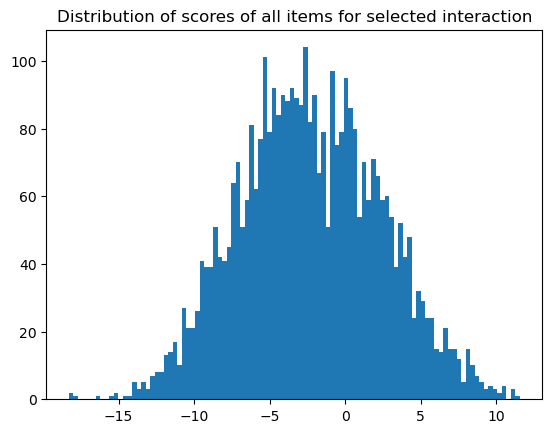

In [10]:
fig,axes = plt.subplots()
axes.hist(array,bins = 100);
axes.set_title('Distribution of scores of all items for selected interaction');


### Experiments(Baseline event selection)

<b>1. Selecting the item which has the least score.</b><br>
This item is the least likely to be selected amongst all the items. Hence, pertubing the sequence over it 
should result in a change in scores.

In [11]:
min_event = array.argmin()
local_event_explaination(min_event)

Assuming all features are model features


alt.HConcatChart(...)

<b>2. Selecting the item which has the highest score.</b><br>
This item is the most likely to be selected amongst all the items.

In [12]:
max_event = array.argmax()
local_event_explaination(max_event)

Assuming all features are model features


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


alt.HConcatChart(...)

The above experiment shows that event 1 is the most important event.As when we pertube keeping this as a baseline, the scores for the recommended top 10 items should increase.


<b>2. Selecting the median item.</b><br>
This item is as likely to be recommended as it is not to be recommended.

In [13]:
median_event = np.argsort(array)[len(array)//2]
local_event_explaination(median_event)

Assuming all features are model features


alt.HConcatChart(...)

Based on this experiment,there is not a large difference between selecting median or the minimum scored item.

### Test Interaction 2

An interaction is randomly selected from the test dataset(Leave one out CV is done when training the model). Now, its event wise calculations are calculated.

In [18]:
model_check = GRU4Recold(args,corpus)
model_check.load_state_dict(torch.load(file_path))
## Set the interactions here(Since local, there is only 1 instance)
history_items = [[2558, 1247, 3318,  364, 1246,  690,    1, 1898, 1900, 2776, 1905, 1248,
        1818, 2506, 2653, 1217, 2100,  496, 1203, 1107]]
## lengths
lengths = [len(x) for x in history_items]
batch_size = len(history_items)
sample = {'history_items':torch.tensor(history_items),\
         'lengths':torch.tensor(lengths),'batch_size':batch_size}
sample_input = torch.tensor(pd.DataFrame(history_items).values).unsqueeze(2)
array = model_check.predict_scores(sample_input).detach().numpy()[0]

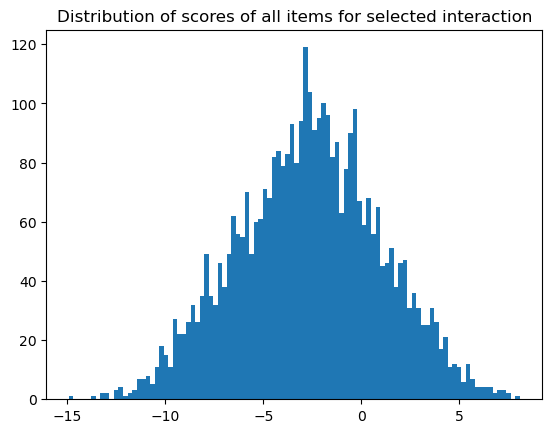

In [19]:
fig,axes = plt.subplots()
axes.hist(array,bins = 100);
axes.set_title('Distribution of scores of all items for selected interaction');

Note: 
Since, the distribution of scores has changed for each interaction or for each perturbed interaction, there is a need to 
normalize the scores in order to compare SHAPLEY values across interactions or when calculating global explanations.

In [20]:
median_event = np.argsort(array)[len(array)//2]
local_event_explaination(median_event)

Assuming all features are model features


alt.HConcatChart(...)

In [21]:
max_event = array.argmax()
local_event_explaination(max_event)

Assuming all features are model features


ValueError: Score difference between baseline and instance (-0.013173580169677734) is too low < 0.1.Baseline score: 0.4864293932914734 | Instance score: 0.4996029734611511.Consider choosing another baseline.

In [22]:
min_event = array.argmin()
local_event_explaination(min_event)

Assuming all features are model features


alt.HConcatChart(...)

### TODO
1. Generate global explanations by normalizing scores.
2. Metric based SHAPLEY calculation:Revise and check values for NDCGs.(In this method, the choice of baseline does not matter. Normalizing is not necessary)